<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/51_Pro_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_PSPNet_%D1%81%D0%B0%D0%BC%D0%BE%D0%BB%D0%B5%D1%82%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Pro

Макс 10 баллов

Напишите PSPNet для сегментации на базе самолетов, добейтесь максимально возможной точности.

# Библиотеки

In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Models
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои
from tensorflow.keras import backend as K # Импортируем модуль backand keras'a
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils # для получения OHE
from tensorflow.keras.preprocessing import image # для работы с изображениями
from google.colab import files # модуль для работы с файлами
from PIL import Image # для работы с изображениями
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt # для построения графиков
import numpy as np
import time
import random
import os # для работы с файловой системой

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cегментация самолетов

# Loss функция

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

# PSPNet

## Загружаем библиотеки

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-6xptqvye
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-6xptqvye
  Running command git submodule update --init --recursive -q


## Загрузка данных и создание обучающей и валидационной выборки

In [ ]:
# Глобальные параметры
img_width = 384 # ширина уменьшенной картинки для PSPNet трансформера
img_height = 384 # высота уменьшенной картинки для PSPNet трансформера

directory = "/content/drive/MyDrive/Базы/Airplane/" # Указываем путь к обучающей выборке с оригинальными изображения
num_classes = 2 # кол-во классов на изображении

In [ ]:
# Создаем пустой список для хранения оригинальных изображений обучающей выборки
images_airplane = []

cur_time = time.time() # засекаем екущее время
for filename in sorted(os.listdir(directory + "Airplane")): # проходим по всем файлам в каталоге по указанному пути
  images_airplane.append(image.load_img(os.path.join(directory + "Airplane", filename),
                                                     target_size = (img_width, img_height))) # ситаем очередную картинку и добавляем ее в список изображения с указанным target_size
print("Обучающая выборка загружена. Время загрузки : ", time.time() - cur_time, "c", sep="") # выводим на экран время загрузки


Обучающая выборка загружена. Время загрузки : 21.340731620788574c


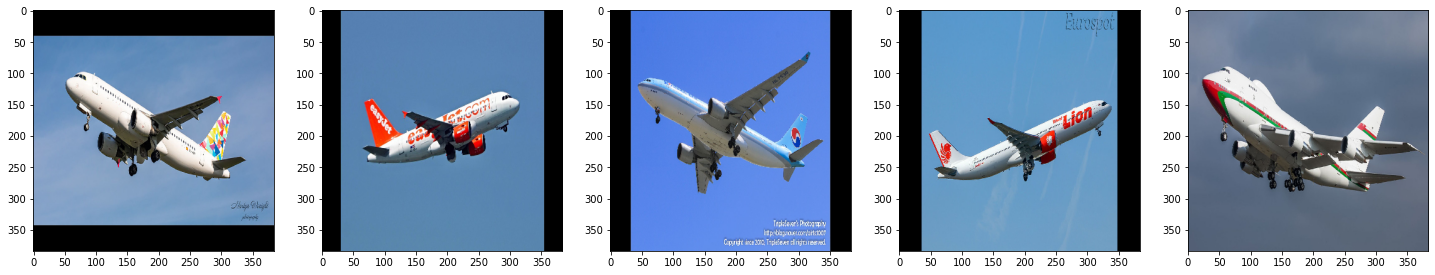

In [ ]:
n = 5 # кол-во случайных выводимых картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) # создаем полотно из n графиков
for i in range(n): # выводим в цикле n случайных изображений
  img = random.choice(images_airplane) # выбираем случайное фото для отображения
  axs[i].imshow(img) # отображаем фото
plt.show() # показываем изображения

In [ ]:
segments_airplane = [] # cоздаем пустой список для хранения оригинальных изображений

cur_time = time.time() # засекаем текущее время
for filename in sorted(os.listdir(directory + "Segment")): # проходим по всем файлам в каталоге по указанному пути
  segments_airplane.append(image.load_img(os.path.join(directory + "Segment", filename),
                                          target_size=(img_width, img_height))) # читаем очередную картинку и добавляем ее в список изображений с указанным target_size
print("Обучающая выборка загружена. Время загрузки: ", time.time() - cur_time, "c", sep="") # отображаем время загрузки картинок обучающей выборки



Обучающая выборка загружена. Время загрузки: 19.112694263458252c


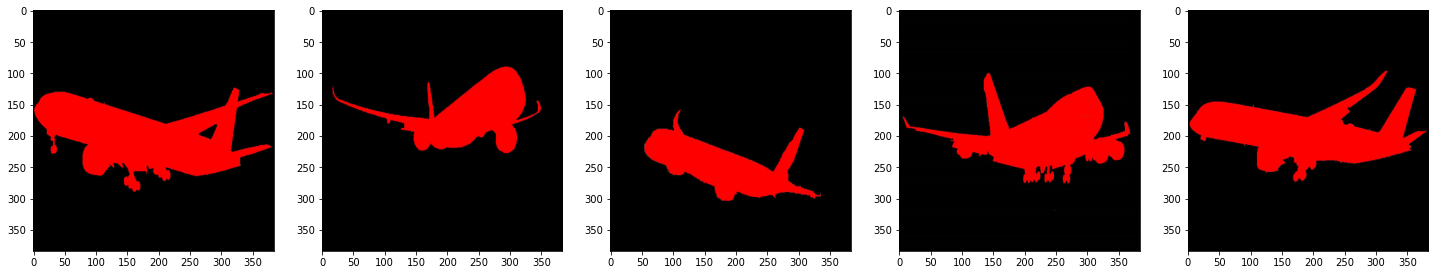

In [ ]:
n = 5 # кол-во случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25,5)) # создаем полотно из n графиков
for i in range(n): # выводим в цикле n случайных изображений
  img = random.choice(segments_airplane) # выбираем случайное фото для отображения
  axs[i].imshow(img) # отображаем фото
plt.show() # показываем изображения



In [ ]:
# Функция преобразования пикселя, сегментированного изображения в индекс (2 класса)
def color2index(color):
  index = 0
  if (color[0] + color[1] + color[2]) > 20: index = 1 # cамолет
  return index

In [ ]:
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0, 0, 0] # фон
  elif index == 1:
    color = [255, 0, 0] # самолет
  return color

In [ ]:
# Функция перевода индекса пикселя в to_categorical
def rgbToohe(y, num_classes):
  y_shape = y.shape  # запоминаем форму массива для решейпа
  y = y.reshape(y.shape[0] * y.shape[1], 3) # решейпим в двумерный массив
  yt = [] # создаем пустой лист
  for i in range(len(y)): # проходим по всем трем каналам изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # преобразуем в numpy массив
  yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # решейпим к исходному размеру
  return yt # возвращаем сформированный массив


In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # создаем пустой список под карты сегментации
  for seg in data: # пробегаемся по всем файлам набора с сегментированными изображениями
    y = image.img_to_array(seg) # переводим в numpy массив размерностью высота - ширина - кол-во каналов
    y = rgbToohe(y, num_classes) # получаем OHE представление сформированного массива
    yTrain.append(y) # добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # каждые 100 шагов
      print(len(yTrain)) # выводим количество обработанных изображений
  return np.array(yTrain) # возвращаем сформированный yTrain

In [ ]:
xTrain = []  # создаем пустой список под обучающую выборку
for img in images_airplane:
  x = image.img_to_array(img) # переводим изображение в numpy массив размерностью: высота - ширина - кол-во каналов
  xTrain.append(x) # добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # переводим в numpy
print(xTrain.shape) # размерность обусчющей выборки

(1000, 384, 384, 3)


In [ ]:
cur_time = time.time()
yTrain = yt_prep(segments_airplane, num_classes)
print("Время обработки: ", round(time.time() - cur_time, 2), "c")

100
200
300
400
500
600
700
800
900
1000
Время обработки:  1479.99 c


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [ ]:
y_train.shape

(900, 384, 384, 2)

## Загрузка PSPNet сети

https://segmentation-models.readthedocs.io/en/latest/api.html#metrics - ссылка на материал

In [ ]:
from segmentation_models import PSPNet
from segmentation_models.utils import set_trainable
# from segmentation_models.losses import DiceLoss
# from segmentation_models.metrics import FScore

In [ ]:
model = PSPNet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, input_shape=(384, 384, 3), classes=num_classes, activation='sigmoid')
 
# Компилируем сеть
model.compile(optimizer=Adam(),
              loss="categorical_crossentropy", 
              metrics=[dice_coef])


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 384, 384, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 390, 390, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

## Обучение PSPNet (fine tuning)

In [ ]:
# pretrain model decoder
model.fit(x_train, y_train, epochs=2)
 


Epoch 1/2
29/29 [==============================] - 21s 530ms/step - loss: 0.1943 - dice_coef: 0.8902
Epoch 2/2
29/29 [==============================] - 15s 499ms/step - loss: 0.0814 - dice_coef: 0.9230


In [ ]:
# # release all layers for training
# set_trainable(model) # set all layers trainable and recompile model

In [ ]:
# continue training
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
29/29 [==============================] - 14s 474ms/step - loss: 0.0597 - dice_coef: 0.9379
Epoch 2/100
29/29 [==============================] - 14s 494ms/step - loss: 0.0492 - dice_coef: 0.9465
Epoch 3/100
29/29 [==============================] - 15s 504ms/step - loss: 0.0449 - dice_coef: 0.9500
Epoch 4/100
29/29 [==============================] - 14s 487ms/step - loss: 0.0435 - dice_coef: 0.9496
Epoch 5/100
29/29 [==============================] - 14s 479ms/step - loss: 0.0400 - dice_coef: 0.9541
Epoch 6/100
29/29 [==============================] - 14s 474ms/step - loss: 0.0388 - dice_coef: 0.9549
Epoch 7/100
29/29 [==============================] - 14s 481ms/step - loss: 0.0357 - dice_coef: 0.9564
Epoch 8/100
29/29 [==============================] - 14s 483ms/step - loss: 0.0354 - dice_coef: 0.9565
Epoch 9/100
29/29 [==============================] - 14s 485ms/step - loss: 0.0318 - dice_coef: 0.9586
Epoch 10/100
29/29 [==============================] - 14s 487ms/step - lo

In [ ]:
# Сохраняем веса
model.save_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/model_PSPNet.h5')

In [ ]:
# Функция создания сети PSPNet
def model_PSPNet(num_classes, input_shape):
  model_pspnet = PSPNet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, input_shape=(384, 384, 3), classes=num_classes, activation='sigmoid')   
 
  # Компилируем сеть
  model_pspnet.compile(optimizer=Adam(),
                loss="categorical_crossentropy", 
                metrics=[dice_coef])
  return model_pspnet 

In [ ]:
#Генерируем сеть и загружаем сохраненные веса
model_pspnet =model_PSPNet(num_classes, (img_width, img_height,3))
model_pspnet.load_weights('/content/drive/MyDrive/Базы/Moдели_сегментация/model_PSPNet.h5')

1/1 [==============================] - 0s 19ms/step


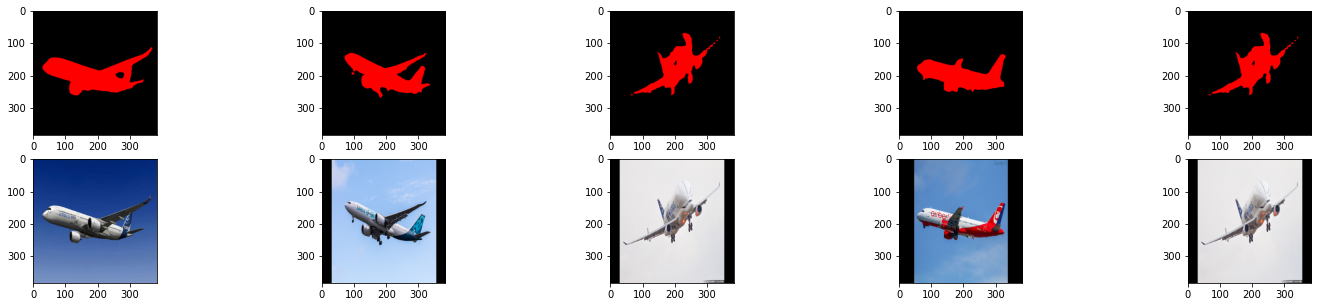

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) # создаем полотно из count граф/
for i, idx in enumerate (indexes): # проходим по всем сгенерированным индексам
  predict = np.array(model_pspnet.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # предиктим картинку
  pr = predict[0] # берем нулевой элемент из предикта
  pr1 = [] # пустой лист под сегментированную картинку из предикта
  pr = pr.reshape(-1, n_classes) # решейпим предикт
  for k in range(len(pr)): # проходим по всем уровням (кол-ва классов)
    pr1.append(index2color(pr[k])) # переводим индекс в пиксель
  pr1 = np.array(pr1) # преобразуем в numpy массив
  pr1 = pr1.reshape(img_width, img_height, 3) # решейпим к размеру изображения
  img = Image.fromarray(pr1.astype("uint8")) # получаем картинку из предикта
  axs[0,i].imshow(img.convert("RGBA")) # отображаем на графике в первой линии
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype("uint8"))) # отображаем в графике на второй линии
